In [5]:
import warnings

warnings.filterwarnings('ignore')

import os

from nba.common import add_game_log_lag, add_game_log_last_5
from tools.hyperparamtuning import HyperParamTuning
from tools.modeler import Modeler
import nba.constants as c

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from hyperopt import hp

import numpy as np
import pandas as pd

import glob
import shap

ROOT_DIR = os.getcwd()[:-17] # verify this points to the root directory of the project


SEED = 1
early_stopping = 50
season = c.SEASON_2022_2023
player_game_log_path = ROOT_DIR + 'data/game_logs/2022-23/player'
player_game_log_csv_files = glob.glob(os.path.join(player_game_log_path, '*.csv'))

log = pd.DataFrame()

ROOT_DIR

'/Users/rmcdevi2/Projects/personal/nba-analysis/'

In [6]:
# Get Data
for f in player_game_log_csv_files:
    df = pd.read_csv(f)
    log = pd.concat([log, df], ignore_index=True)

log.to_csv(ROOT_DIR + '/data/game_logs/2022-23/player_game_log_2022-2023', index=False)
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,OPP_TEAM_ID
0,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201138,2023-03-29,NYK vs. MIA,W,...,2,0,0,0,1,1,3,-3,2022-23,1.610613e+09
1,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201124,2023-03-27,NYK vs. HOU,W,...,1,1,0,0,0,4,26,11,2022-23,1.610613e+09
2,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201093,2023-03-23,NYK @ ORL,L,...,1,0,2,3,4,5,23,20,2022-23,1.610613e+09
3,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201084,2023-03-22,NYK @ MIA,L,...,4,1,0,1,5,1,15,-6,2022-23,1.610613e+09
4,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201073,2023-03-20,NYK vs. MIN,L,...,4,0,0,0,4,10,57,-6,2022-23,1.610613e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200064,2022-10-26,DEN vs. LAL,W,...,3,4,0,0,3,4,31,28,2022-23,1.610613e+09
1486,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200051,2022-10-24,DEN @ POR,L,...,1,0,0,0,5,4,9,-10,2022-23,1.610613e+09
1487,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200035,2022-10-22,DEN vs. OKC,W,...,3,1,1,0,2,7,19,18,2022-23,1.610613e+09
1488,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200026,2022-10-21,DEN @ GSW,W,...,5,0,0,1,4,10,26,-3,2022-23,1.610613e+09


In [7]:
# Preprocess Data
log = add_game_log_lag(log)
log = add_game_log_last_5(log)
log.sort_values(by=[c.GAME_DATE])
log = log[c.PTS_PREDICTION_MASK]
log.dropna()

X, y = log.drop(c.PTS, axis=1), log[c.PTS]

cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype('category')

In [8]:
# Train Model
rmse = {
    'base_model': 0,
    'tuned_model': 0,
}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 1000
}
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)


In [9]:
modeler = Modeler(
    XGBRegressor(),
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
)

modeler.train(params)
rmse['base_model'] = modeler.rmse()

[0]	validation_0-rmse:8.65652	validation_1-rmse:9.62072
[100]	validation_0-rmse:0.16397	validation_1-rmse:10.35167
[200]	validation_0-rmse:0.00582	validation_1-rmse:10.36654
[300]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[400]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[500]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[600]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[700]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[800]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[900]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
[999]	validation_0-rmse:0.00095	validation_1-rmse:10.36661
RSME: 10.36661399946437


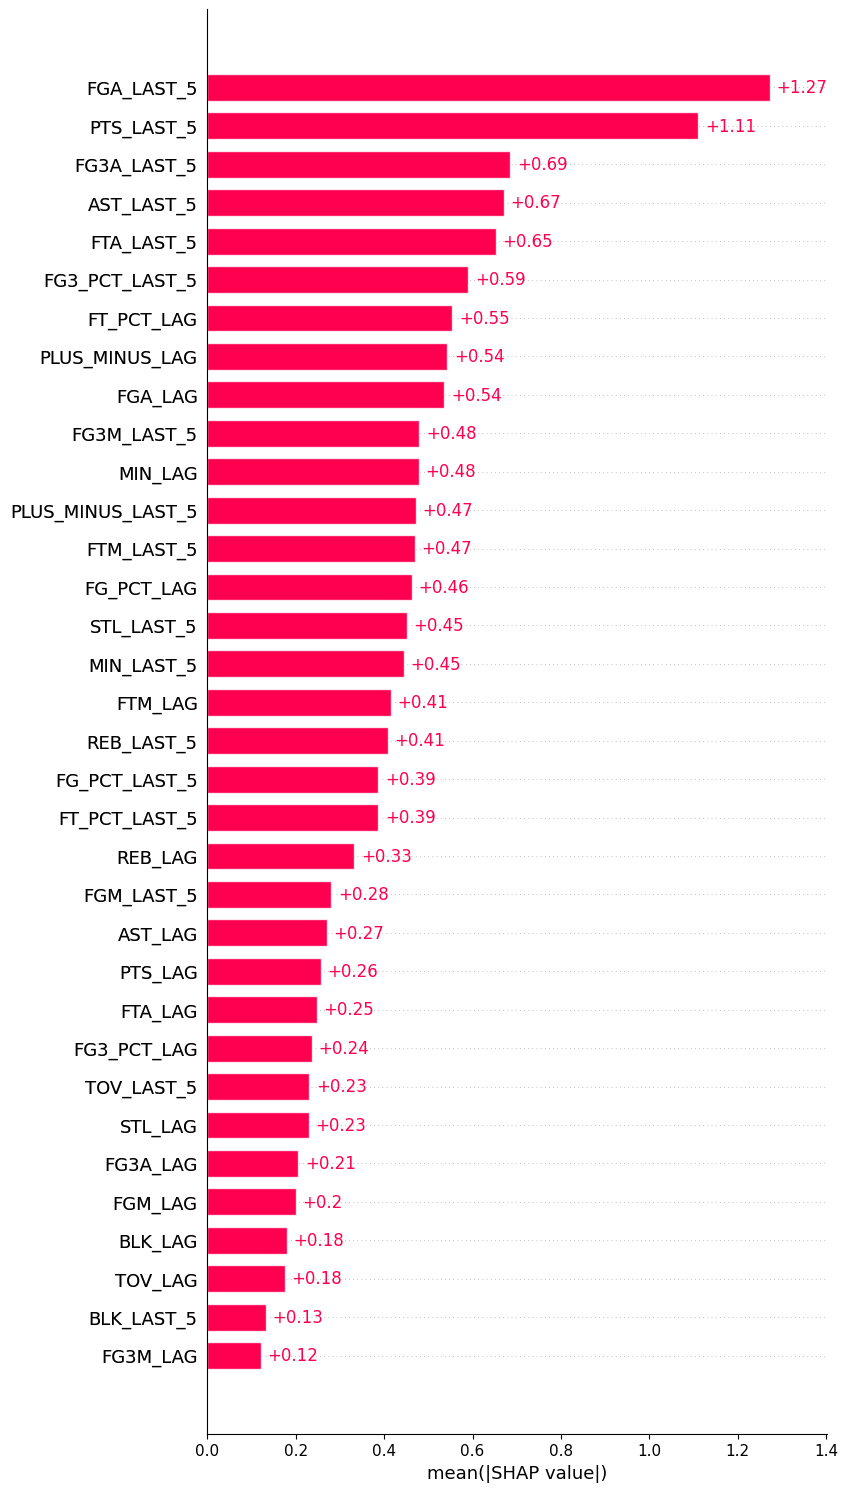

In [10]:
# Plot baseline model
shap.plots.bar(modeler.shap_values(), max_display=100)

In [11]:
# Hyperparameter Tuning
space = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
}

hpt = HyperParamTuning(modeler, space, SEED)
best = hpt.optimize(250)
best

[0]	validation_0-rmse:8.72418	validation_1-rmse:9.76424
[100]	validation_0-rmse:4.41375	validation_1-rmse:9.73567
[200]	validation_0-rmse:4.03619	validation_1-rmse:9.74347
[300]	validation_0-rmse:3.92968	validation_1-rmse:9.74550
[303]	validation_0-rmse:3.92968	validation_1-rmse:9.74550
RSME: 9.745504506548043                                
[0]	validation_0-rmse:9.14131	validation_1-rmse:9.77810                         
[100]	validation_0-rmse:6.78837	validation_1-rmse:9.54693                       
[114]	validation_0-rmse:6.74805	validation_1-rmse:9.55583                       
RSME: 9.555827103351973                                                         
[0]	validation_0-rmse:9.01207	validation_1-rmse:9.73021                         
[100]	validation_0-rmse:7.07270	validation_1-rmse:9.46230                       
[200]	validation_0-rmse:6.86234	validation_1-rmse:9.47546                       
[300]	validation_0-rmse:6.78573	validation_1-rmse:9.46531                       
[400]	va

{'colsample_bytree': 0.6612907171662629,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'gamma': 6.5852368199011,
 'max_depth': 3.0,
 'min_child_weight': 0.0,
 'n_estimators': 570.0,
 'objective': 'reg:squarederror',
 'reg_alpha': 165.0,
 'reg_lambda': 0.1958756309863317,
 'subsample': 1.0}

In [12]:
modeler.train(best)
rmse['tuned_model'] = modeler.rmse()
rmse

[0]	validation_0-rmse:9.31373	validation_1-rmse:9.82357
[100]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
[200]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
[300]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
[400]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
[500]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
[569]	validation_0-rmse:8.13216	validation_1-rmse:9.30841
RSME: 9.308410098496331


{'base_model': 10.36661399946437, 'tuned_model': 9.308410098496331}

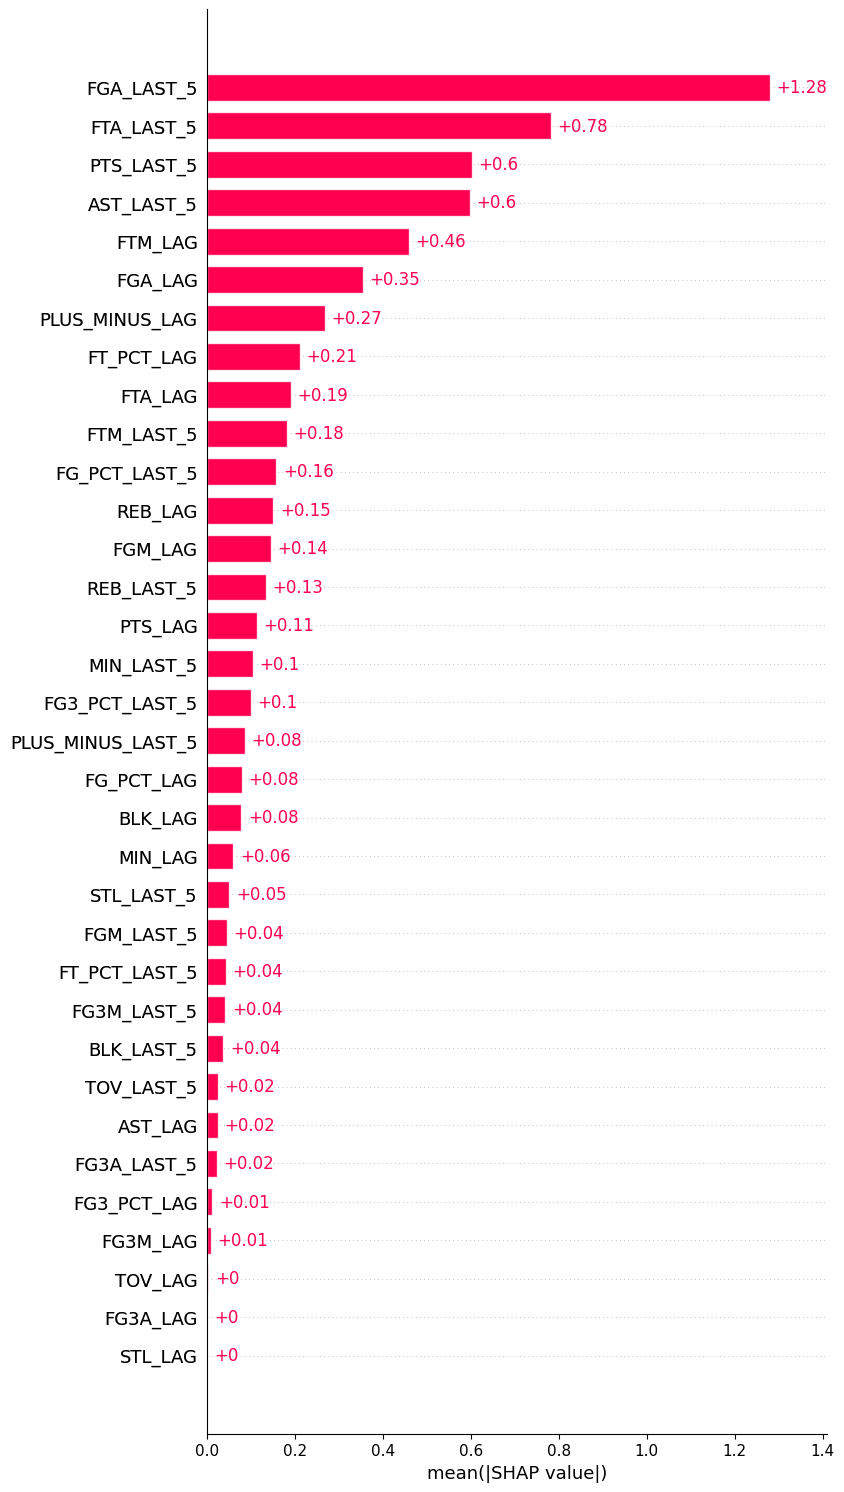

In [13]:
shap.plots.bar(modeler.shap_values(), max_display=100)